[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aunz/ds/blob/master/KNN.ipynb)

# k Nearest Neighbors


We will implement k nearest neighbors in Python and hopefully at the end of this notebook, you will understand how KNN works.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import the iris dataset from sklearn
iris = __import__('sklearn').datasets.load_iris()

# overview of the data
print('Number of observation: {}\nNumber of feature: {}'.format(*iris.data.shape))
print('Target category:', iris.target_names)
pd.DataFrame(iris.data, columns=iris.feature_names, index=iris.target).head(10)

Number of observation: 150
Number of feature: 4
Target category: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
0,4.9,3.0,1.4,0.2
0,4.7,3.2,1.3,0.2
0,4.6,3.1,1.5,0.2
0,5.0,3.6,1.4,0.2
0,5.4,3.9,1.7,0.4
0,4.6,3.4,1.4,0.3
0,5.0,3.4,1.5,0.2
0,4.4,2.9,1.4,0.2
0,4.9,3.1,1.5,0.1


In this dataset, there are:
- 150 observations
- 4 features: sepal length, sepal width, petal length, petal width
- 3 species of flower in the dataset: Setosa (0), Versicolor (1), Virginica (2). 

From the graphs below, we can see that each species can be more or less clustered together using various features. For example, setosa has smaller petal septal length, petal length and petal width compared to the other two species.

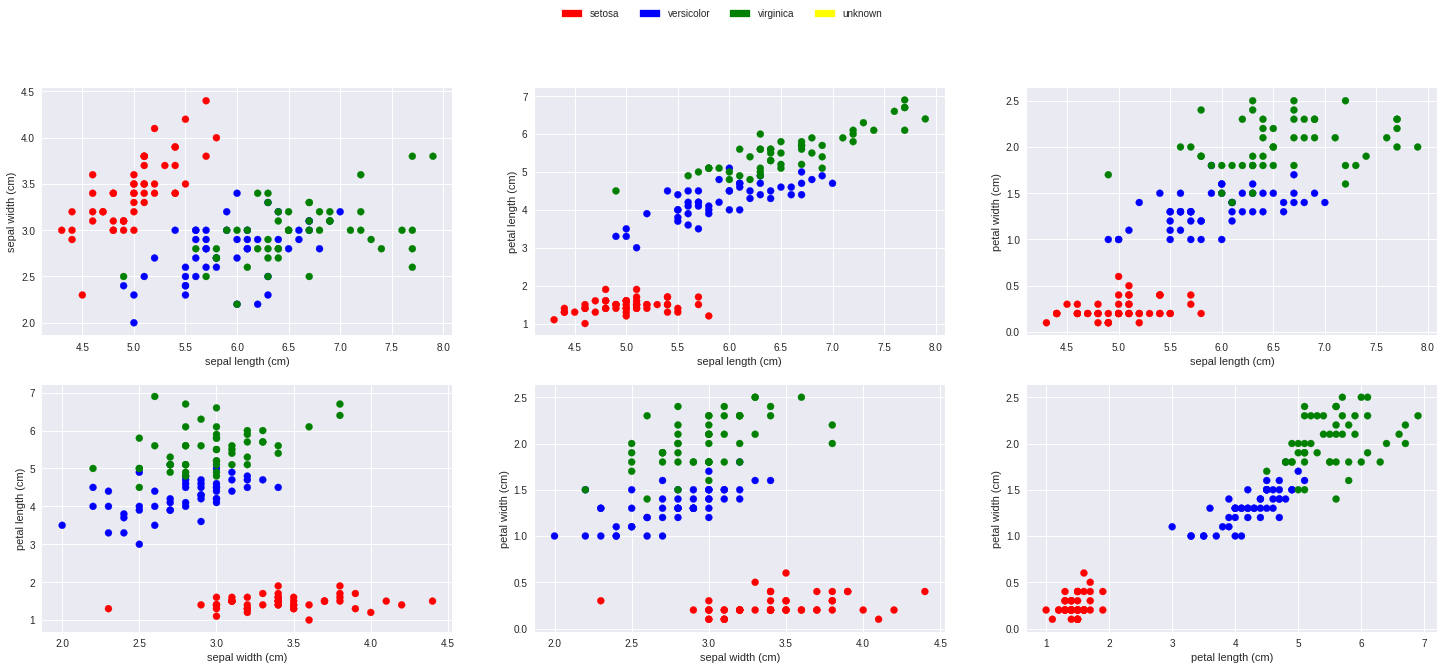

In [128]:
# a helper function to plot
def plot(ax, x1, x2):
    colors = list(map(lambda x: { 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow' }[x], iris.target))
    ax.scatter(iris.data[:, x1], iris.data[:, x2], c=colors)
    ax.set_xlabel(iris.feature_names[x1])
    ax.set_ylabel(iris.feature_names[x2])

fig, ax = plt.subplots(2, 3, figsize=(25, 10))
plot(ax[0][0], 0, 1)
plot(ax[0][1], 0, 2)
plot(ax[0][2], 0, 3)
plot(ax[1][0], 1, 2)
plot(ax[1][1], 1, 3)
plot(ax[1][2], 2, 3)

fig.legend(handles=[
    mpatches.Patch(color='red', label=iris.target_names[0]),
    mpatches.Patch(color='blue', label=iris.target_names[1]),
    mpatches.Patch(color='green', label=iris.target_names[2]),
    mpatches.Patch(color='yellow', label='unknown'),
], loc='upper center', ncol=4);


The question is: given a sample without a label, can we classify it using its features?

The graph on the left below shows 4 such new samples, can you guess their labels?
- Sample 1 is close to Setosa, so it's likely to be Setosa,
- Sample 2 is close to Virginica, so it's likely to be Virginica
- Sample 3 is close to both Versicolor and Virginica, can be either
- Sample 4 is close to both Versicolor and Virginica too, can be either

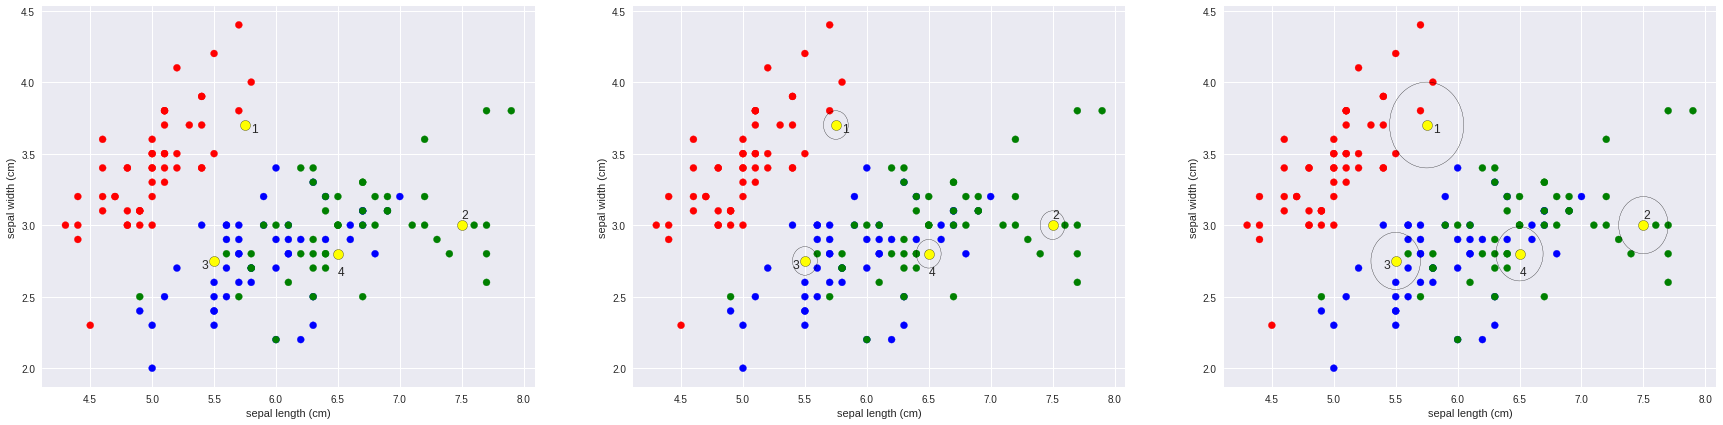

In [216]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7))
for i in ax:
    plot(i, 0, 1)
    i.scatter([5.75], [3.7], c='yellow', edgecolor='black', s=100); i.text(5.8, 3.65, '1') # sample 1
    i.scatter([7.5], [3.0], c='yellow', edgecolor='black', s=100); i.text(7.5, 3.05, '2') # sample 2
    i.scatter([5.5], [2.75], c='yellow', edgecolor='black', s=100); i.text(5.4, 2.7, '3', horizontalalignment='left') # sample 3
    i.scatter([6.5], [2.8], c='yellow', edgecolor='black', s=100); i.text(6.5, 2.65, '4'); # sample 4
    
# sample 1 circles
ax[1].add_patch(mpatches.Circle(xy=(5.75, 3.7), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(5.75, 3.7), radius=0.3, facecolor='none', edgecolor='black'))

# sample 2 circles
ax[1].add_patch(mpatches.Circle(xy=(7.5, 3.0), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(7.5, 3.0), radius=0.2, facecolor='none', edgecolor='black'))

# sample 3 circles
ax[1].add_patch(mpatches.Circle(xy=(5.5, 2.75), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(5.5, 2.75), radius=0.2, facecolor='none', edgecolor='black'))

# sample 4 circles
ax[1].add_patch(mpatches.Circle(xy=(6.5, 2.8), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(6.5, 2.8), radius=0.19, facecolor='none', edgecolor='black'))

**KNN** works by finding the nearest neighbour to the sample we are interested in.

In the middle graph above, in each sample, we can draw a circle around each sample.
- In sample 1, the nearest is obviously a Setosa,
- In sample 2, the nearest is Virginica
- In sample 3, we have 2 species
- In sample 4, the nearest is Virginica

In the left graph above, we can draw a bigger around each sample.
- In sample 3, there are 4 Versicolor, 1 Virginica. So we can label this sample as Versicolor
- In sample 4, the circle encompasses 3 Virginica, 2 Versicolor. So we can lable this sample as Virginica

"Nearest" in this sense means distance. There are many ways to calculate distances, one of them is [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

In a 2D space, the disance between point A($x_A$, $y_A$) and B($x_B$, $y_B$) is given:   
\begin{equation*}
\ distance = \sqrt{(x_A - x_B)^2 + (y_A -  y_B)^2}
\end{equation*}

In a 3D space, the disance between point A($x_A$, $y_A$, $z_A$) and B($x_B$, $y_B$, $z_B$) is given:   
\begin{equation*}
\ distance = \sqrt{(x_A - x_B)^2 + (y_A - y_B)^2 + (z_A - z_B)^2}
\end{equation*}

Now let code

In [0]:
def distance(A, B):
    # compute distance between A and B
    pass
    
    
distance([], [])